# Задание 1. Binary classification

Описание:
Хотим предсказывать выход в просроченный платеж пользователей. Таргет - 1 - вышел, 0 - не вышел

Задачи:

1 - улучшить качество модели от baseline

2 - добавление факторов аргументируйте визуализацией и комментарием в коде

3 - сделать кросс валидацию с перемешиванием для оценки итогового результата StratifiedShuffleSplit, разбиение на 5 фолдов

4 - качество оценивать по roc auc и выведете средний результат по 5 фолдам. Данный результат выведите в коде и запишите в итоговую анкету как ответ к Заданию 1.

6 - напишите 3-5 действий по итогу оценки качества, которые Вы бы сделали для улучшения качества модели, если бы Вам дали на работу еще 5 рабочих дней. Ответ напишите в комментариях к коду в конце.

In [1]:
import pandas as pd


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate , train_test_split , StratifiedShuffleSplit
from sklearn import   linear_model, metrics
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

Исходная модель baseline

In [3]:
train_directory ='train.csv'

train = pd.read_csv(train_directory, header=0 )

train['y'] = [1 if y == 'yes' else 0 for y in train['y']]

X = train[['age' , 'previous']][:]
y = train['y'][:]
classifier = RandomForestClassifier()
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)
classifier.fit(train_data , train_labels)
pred_labels = classifier.predict(test_data)
print('Качество исходной модели: ',metrics.roc_auc_score(test_labels, pred_labels))

Качество исходной модели:  0.5363532674330188


# 1. Описательная статистика

In [4]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [5]:
train.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,3222.000000,3222.000000,3222.000000,3222.000000,3222.000000,3222.00000,3222.000000,3222.000000,3222.000000,3222.000000,3222.000000
mean,39.949100,254.391682,2.525140,961.075729,0.191186,0.09162,93.587576,-40.580261,3.618885,5166.177654,0.112353
std,10.292639,253.617387,2.546888,190.390725,0.552781,1.55203,0.578841,4.575879,1.734232,74.028498,0.315849
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.40000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.80000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.10000,93.876000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,314.000000,3.000000,999.000000,0.000000,1.40000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.40000,94.767000,-26.900000,5.045000,5228.100000,1.000000


Выделяем качественные и количественные показатели

In [6]:
cat = []
num = []

for i in train.dtypes.keys():
    if train.dtypes[i] == 'object' and i != 'y':
        cat.append(i)
    elif i != 'y':
        num.append(i)

Работаем с качественными признаками

In [7]:
train[cat].head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,nonexistent
1,services,single,high.school,no,no,no,telephone,may,fri,nonexistent
2,services,married,high.school,no,yes,no,telephone,jun,wed,nonexistent
3,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,nonexistent
4,admin.,married,university.degree,no,yes,no,cellular,nov,mon,nonexistent


Попробуем визуально проанализировать значимость факторов. 
Для этого оценим количество дефолтов по категориальным признакам и выделить наиболее значимые.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


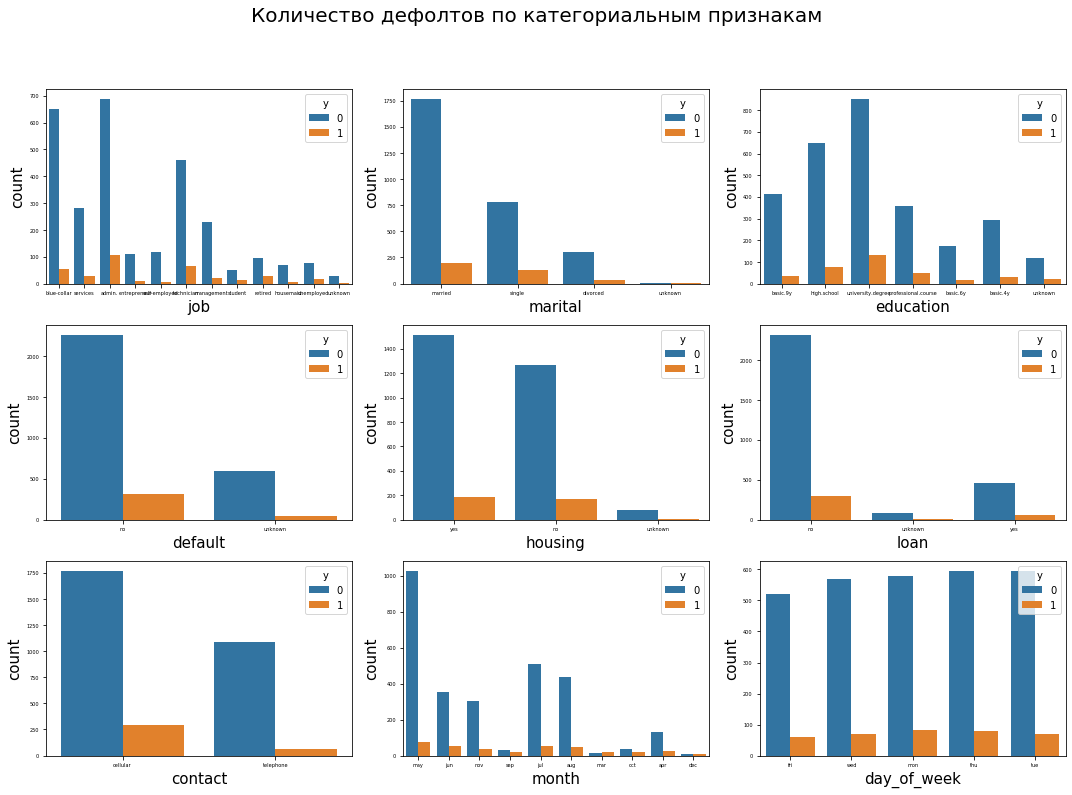

In [8]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
jitter = [[False, 1], [0.5, 0.2]]

k=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=5)
        ax[j][i].set_xlabel(cat[i+j], fontsize=15, position=(.5,20))
        ax[j][i].set_ylabel('count', fontsize=15)
        ax[j][i] = sns.countplot(x=cat[k], hue='y', data=train, ax=ax[j][i])
        k+=1
        if k == 11:
            break
    
fig.suptitle('Количество дефолтов по категориальным признакам', position=(.5,1.1), fontsize=20)
fig.tight_layout()

fig.show()

Из графиков видно, что для таких признаков как 'job','education','default'и'contact' есть существенные различия по количеству дефолтов внутри класса в зависимости от значения переменной.Из этого можно сделать вывод, что эти признаки могут влиять на целевую переменную. Также, есть графики признаков,где уровень дефолтов не меняется внутри класса:'month','day_of_week', их можно исклучить из модели.

Переходим к анализу колличественных признаков.

In [10]:
train[num].head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8


Построим матрицу корреляции колличественных переменных, чтобы оценить их степень влияния на целевую переменную и друг на друга.

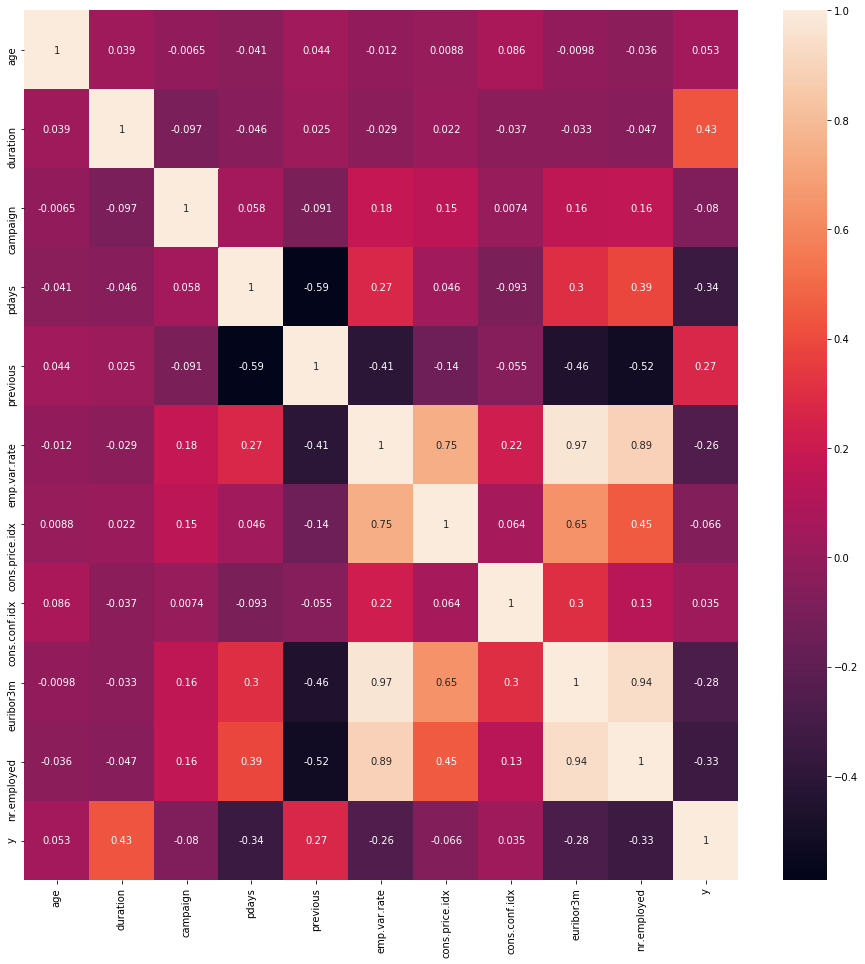

In [11]:
plt.figure(figsize=(16,16))
sns.heatmap(train.corr(),annot=True)

По матрице корреляции видно, что Y больше всего коррелирует с 'duration','pdays','previous','nr.employed,'emp.var.rate' и 'euribor3m'. Это свидетельствует об их значимости. Также, стоит отметить, что эти признаки коррелируют друг с другом. Для улучшения качества модели нежелательно включать в нее сильно коррелирующие между собой факторы.

Закодируем строкове переменные для построения матрицы корреляции и определения стат.значимости.

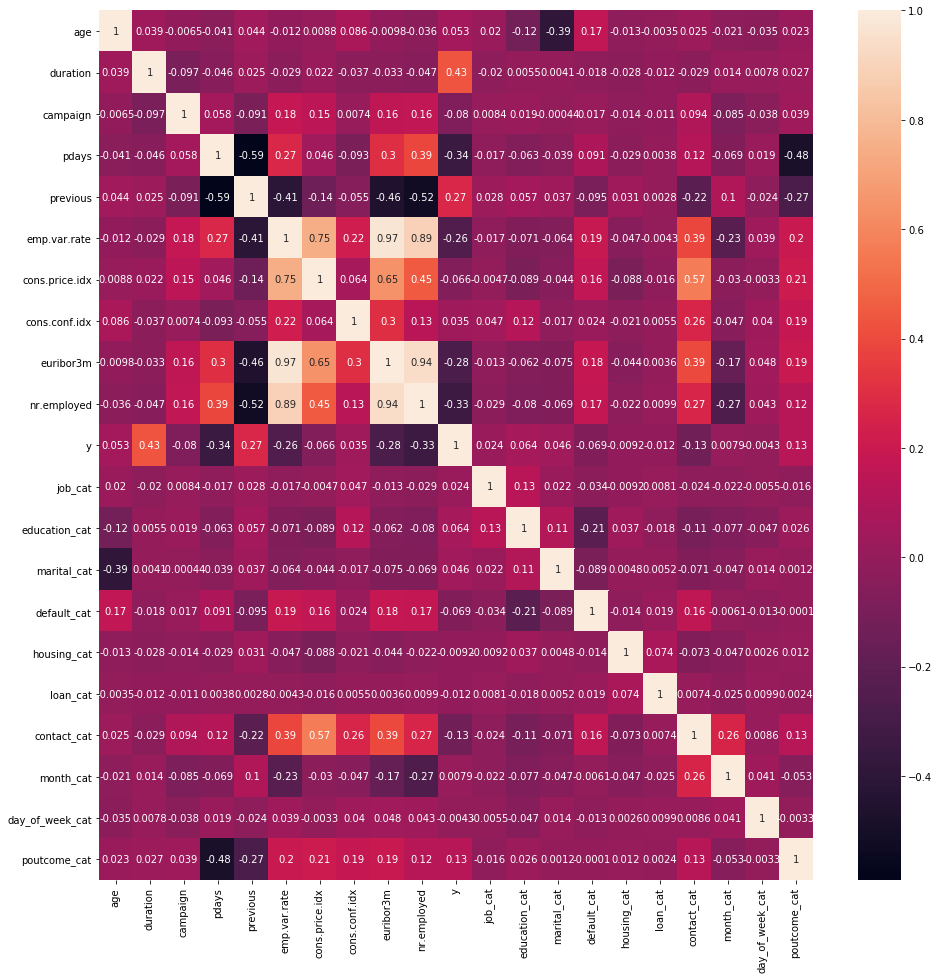

In [12]:
le=LabelEncoder()
le.fit(train['job'])
train['job_cat']=le.transform(train['job'])
del train['job']

le.fit(train['education'])
train['education_cat']=le.transform(train['education'])
del train['education']

le.fit(train['marital'])
train['marital_cat']=le.transform(train['marital'])
del train['marital']

le.fit(train['default'])
train['default_cat']=le.transform(train['default'])
del train['default']

le.fit(train['housing'])
train['housing_cat']=le.transform(train['housing'])
del train['housing']

le.fit(train['loan'])
train['loan_cat']=le.transform(train['loan'])
del train['loan']

le.fit(train['contact'])
train['contact_cat']=le.transform(train['contact'])
del train['contact']

le.fit(train['month'])
train['month_cat']=le.transform(train['month'])
del train['month']

le.fit(train['day_of_week'])
train['day_of_week_cat']=le.transform(train['day_of_week'])
del train['day_of_week']

le.fit(train['poutcome'])
train['poutcome_cat']=le.transform(train['poutcome'])
del train['poutcome']

plt.figure(figsize=(16,16))
sns.heatmap(train.corr(),annot=True)

По матрице видно, что больше всего с целевой переменной коррелируют признаик 'education_cat','contact_cat'и 'defualt_cat'.

Таким образом, после проведенного анализа данных были выделены наиболее значимые признаки: 'job','education', 'default', 'contact','duration','pdays','previous','nr.employed,'emp.var.rate' и 'euribor3m'.

# Тестирование моделей

Построим три модели, базирующиеся на всех количественных признакаха, на признаках,определенных на основе описательной статистики, и на всех признаках.
Оценим качество моделей по roc auc и среднему результату кросс валидации с перемешиванием StratifiedShuffleSplit(разбиение на 5 фолдов).

1. Модель на колличественных признаках

In [14]:
y = train['y'][:]
X = train[num][:]
classifier = RandomForestClassifier()
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)
classifier.fit(train_data , train_labels)
print('Качество модели 1 по roc auc: ',metrics.roc_auc_score(test_labels,classifier.predict_proba(test_data)[:,1] ))
cv=ShuffleSplit(n_splits=5)
cross=cross_val_score(classifier,train_data,train_labels,scoring='roc_auc',cv=4)
print ('StratifiedShuffleSplit на 5 фолдов модели 1: ',cross)
print('Средний результат по 5 фолдам модели 1: ',cross.mean())

Качество модели 1 по roc auc:  0.8989962502286445
StratifiedShuffleSplit на 5 фолдов модели 1:  [0.93868771 0.9341494  0.93819286 0.90148219]
Средний результат по 5 фолдам модели 1:  0.9281280383971465


2. Модель на признаках, выделенных при описательной статистике

In [15]:
y = train['y'][:]
X = train[['duration', 'euribor3m', 'age', 'nr.employed', 'pdays', 'job_cat', 'education_cat', 'day_of_week_cat', 'campaign', 'cons.conf.idx','previous','emp.var.rate','default_cat','contact_cat']][:] 
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)
classifier.fit(train_data , train_labels)
print('Качество модели 2 по roc auc: ',metrics.roc_auc_score(test_labels, classifier.predict_proba(test_data)[:,1]))
cross=cross_val_score(classifier,train_data,train_labels,scoring='roc_auc',cv=4)
print ('StratifiedShuffleSplit на 5 фолдов модели 2: ',cross)
print('Средний результат по 5 фолдам модели 2: ',cross.mean())

Качество модели 2 по roc auc:  0.9298260869565218
StratifiedShuffleSplit на 5 фолдов модели 2:  [0.92463359 0.91970348 0.93395389 0.94492959]
Средний результат по 5 фолдам модели 2:  0.9308051348766389


In [16]:
y = train['y'][:]
del train['y']
X = train[:][:]
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)
classifier.fit(train_data , train_labels)
print('Качество модели 3 по roc auc: ',metrics.roc_auc_score(test_labels, classifier.predict_proba(test_data)[:,1]))
cross=cross_val_score(classifier,train_data,train_labels,scoring='roc_auc',cv=cv)
print ('StratifiedShuffleSplit на 5 фолдов модели 3: ',cross)
print('Средний результат по 5 фолдам модели 3: ',cross.mean())

Качество модели 3 по roc auc:  0.9140690037924336
StratifiedShuffleSplit на 5 фолдов модели 3:  [0.95059682 0.91746795 0.9193323  0.92919255 0.94152338]
Средний результат по 5 фолдам модели 3:  0.9316225973706793


Оценим стат.значимость признаков

In [17]:
feature_imp = pd.Series(classifier.feature_importances_,index=train.columns).sort_values(ascending=False)
#print(feature_imp)

Визуализируем полученные данные.Верхние коэффициента наиболее значимы, нижние нет.

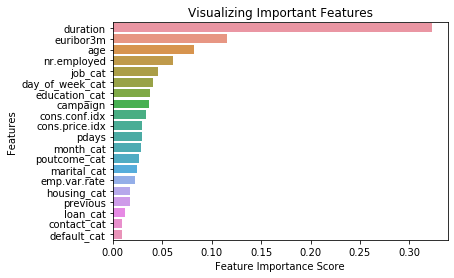

In [18]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Полученные данные согласовываются с описательной статистикой.

# Вывод

Лучший результат показала модель, построенная на всех признаках. Средний результат по 5 фолдам для нее составил 0,94. В целом, можно сказать, что все 3 модели достаточно точны и могут использоваться на практике.

# Напишите 3-5 действий по итогу оценки качества, которые Вы бы сделали для улучшения качества модели, если бы Вам дали на работу еще 5 рабочих дней.

1. Доработала описательную статистику (анализ пропусков, нормализация, выявление аномалий).
2. Попробовала бы ансамбли деревьев и нейросети.
3. Визуализировала полученные результаты.